# Projet n°3 : Application au service de la santé publique

### Partie 1 : Nettoyage des données

Dans ce notebook, je m'intéresse au Projet n°3 de la formation Data Scientist OpenClassrooms. L'objectif est de concevoir une idée d'application de santé publique, qui ferait appel aux données de Open Food Facts, retrouvables à cette adresse : [Open Food Facts](https://world.openfoodfacts.org/). Pour notre analyse nous n'utilisons pas le jeu complet mais un echantillon de 321000 lignes fournis dans l'énoncé OC.
La première étape de ce projet est de nettoyer le dataset et de conserver et remplir les données qui vont nous intéresser dans l'optique de la mise en place de notre application.

In [2]:
#On commence par importer les librairies dont on va avoir besoin pour procéder au nettoyage

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns
import re

In [3]:
#On importe le jeu de données

products = pd.read_csv('Projet 3/products.csv', sep='\t', low_memory=False)

In [4]:
#Regardons un aperçu des premières lignes afin de voir à quoi ressemble ce dataset

products.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
products.info(162, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 162 columns):
 #    Column                                      Non-Null Count   Dtype  
---   ------                                      --------------   -----  
 0    code                                        320749 non-null  object 
 1    url                                         320749 non-null  object 
 2    creator                                     320770 non-null  object 
 3    created_t                                   320769 non-null  object 
 4    created_datetime                            320763 non-null  object 
 5    last_modified_t                             320772 non-null  object 
 6    last_modified_datetime                      320772 non-null  object 
 7    product_name                                303010 non-null  object 
 8    generic_name                                52795 non-null   object 
 9    quantity                                    104819 non-nu

<AxesSubplot: >

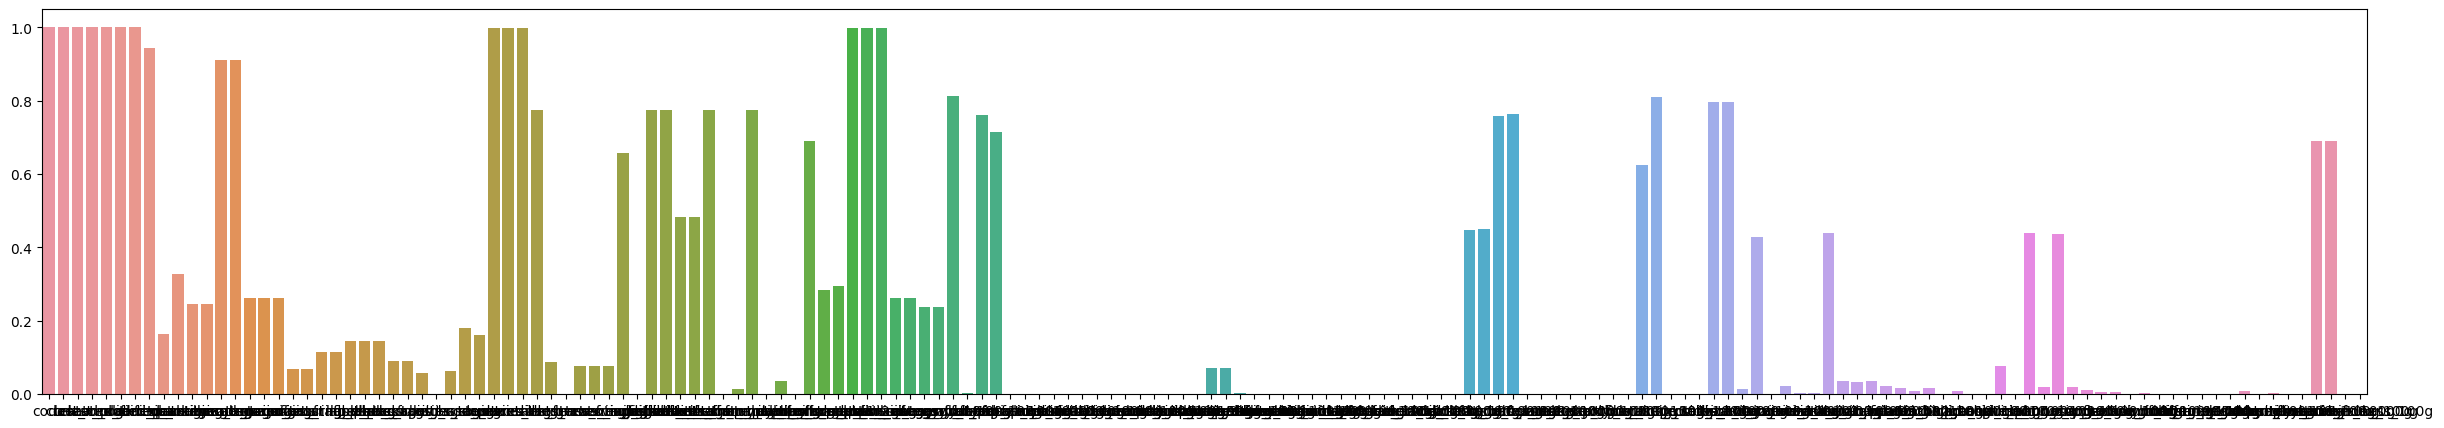

In [6]:
rcParams['figure.figsize'] = (30,5)
#On peut représenter le taux de remplissages des valeurs rapidement avec un petit graphique
data = pd.DataFrame(products.notna().mean()).T
sns.barplot(data)

On voit déjà que de nombreuses variables sont très peu remplies vorie pas du tout remplies. On ne va pas faire notre tri sur cela, mais cela nous donne déjà un aperçu du dataset à ce niveau.

#### Sélection des variables

On peut voir qu'on a énormément de variables, dont de nombreuses avec très peu de remplissage qui ne vont donc pas pouvoir nous servir. De plus, on souhaite créer une application qui s'intéresserait aux valeurs nutritionelles journalières recommandées, donc on va se concentrer sur ces variables, ainsi que certaines permettant d'identifier le produit.

In [30]:
base = list(range(0,162))
keep = [7,12,53,54,55,59,63,65,66,101,102,111,112,116,117,119,121,122,124,127,131,136,138,139,140,141]
drop = [x for x in base if x not in keep]

On garde ainsi uniquement : Le nom et la marque du produit afin de l'identifier et de retirer les doublons. Le nutriscore qui nous servira lors des analyses. Les groupes pnns qui nous permettent de catégoriser les différents produits. La variable 'main_category' est moins précise et utile que les groupes pnns, mais elle va nous servir notamment sur le tri. Enfin, on a gardé les principaux éléments nutritionnels qui nous intéresse pour notre application.

In [31]:
products.drop(products.columns[drop],axis=1, inplace=True)

In [32]:
products

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,main_category,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,...,vitamin-d_100g,vitamin-e_100g,vitamin-c_100g,vitamin-pp_100g,vitamin-b12_100g,potassium_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g
0,Farine de blé noir,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Banana Chips Sweetened (Whole),NaN,d,NaN,NaN,NaN,2243.0,28.57,28.57,64.29,...,NaN,NaN,0.0214,NaN,NaN,NaN,0.000,NaN,0.00129,NaN
2,Peanuts,Torn & Glasser,b,NaN,NaN,NaN,1941.0,17.86,0.00,60.71,...,NaN,NaN,0.0000,NaN,NaN,NaN,0.071,NaN,0.00129,NaN
3,Organic Salted Nut Mix,Grizzlies,d,NaN,NaN,NaN,2540.0,57.14,5.36,17.86,...,NaN,NaN,NaN,NaN,NaN,NaN,0.143,NaN,0.00514,NaN
4,Organic Polenta,Bob's Red Mill,NaN,NaN,NaN,NaN,1552.0,1.43,NaN,77.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320767,Tomato & ricotta,Panzani,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",Trader Joe's,b,NaN,NaN,NaN,0.0,0.00,0.00,0.00,...,NaN,NaN,0.0000,NaN,NaN,0.0,0.000,NaN,0.00000,NaN
320769,乐吧泡菜味薯片,乐吧,NaN,Salty snacks,Appetizers,en:chips-and-fries,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320770,Tomates aux Vermicelles,Knorr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On garde ainsi 26 variables variables, dont le nom du produit, la marque, la catégorie et de nombreuses informations nutritionelles. Les deux premières vont nous permettre d'identifier chaque produit individuellement, les catégories vont nous servir pour les analyses, et le reste des variables sont indispensables pour notre idée d'application. Dans ces dernières, on a beaucoup de valeurs manquantes donc on va essayer de compléter cela afin d'obtenir un jeu de données exploitable pour notre application.

La quantité de variables est cependant toujours grande, et il sera compliqué d'imputer toutes les valeurs manquantes, notamment pour les différentes vitamines et minéraux. On va donc regrouper les variables vitamines qui sont assez éparses et moins prioritaires en une unique variable 'vitamins' qui sera constituée de la somme des vitamines. On va faire de même pour les minéraux.
Ces donneés seront moins précises et leur utilisation sera moins affinée pour notre application, mais les valeurs manquantes sont trop nombreuses et trop compliquées à imputer.

De plus, on va en profiter pour retirer les valeurs aberrantes avant d'assembler nos nouvelles variables afin de ne pas perdre trop d'informations. Les quantités de vitamines et de minéraux sont généralement très faibles, et les apport journaliers recommandés sont très bas, avec des maximums notamment pour la vitamine C a 110mg/jour et de 900mg/jour pour le Calcium. Ces valeurs sont évidemment sensées être réparties sur l'ensemble de l'alimentation dans une journée, on peut donc déterminer des maximums pour retirer les valeurs aberrantes individuellement sur chaque variable.

In [33]:
vit = products.loc[:,products.columns.str.contains('vitamin')].columns
for vita in vit :
    products = products.mask(products[vita]>0.2, products.assign(**{vita: np.nan}))
products['vitamins_100g'] = products.loc[:,vit].sum(axis=1, skipna = True)

In [34]:
minerals = ['potassium_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g']
for mine in minerals :
    products = products.mask(products[mine]>1, products.assign(**{mine: np.nan}))
products['minerals_100g'] = products.loc[:,minerals].sum(axis=1, skipna=True)

In [35]:
products.drop(vit, axis=1, inplace = True)
products.drop(minerals, axis=1, inplace=True)

In [36]:
products

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,main_category,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
0,Farine de blé noir,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000
1,Banana Chips Sweetened (Whole),NaN,d,NaN,NaN,NaN,2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000,0.0214,0.00129
2,Peanuts,Torn & Glasser,b,NaN,NaN,NaN,1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,0.0000,0.07229
3,Organic Salted Nut Mix,Grizzlies,d,NaN,NaN,NaN,2540.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482,0.0000,0.14814
4,Organic Polenta,Bob's Red Mill,NaN,NaN,NaN,NaN,1552.0,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN,0.0000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320767,Tomato & ricotta,Panzani,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000
320768,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",Trader Joe's,b,NaN,NaN,NaN,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00000,0.000,0.0000,0.00000
320769,乐吧泡菜味薯片,乐吧,NaN,Salty snacks,Appetizers,en:chips-and-fries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000
320770,Tomates aux Vermicelles,Knorr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000


<AxesSubplot: >

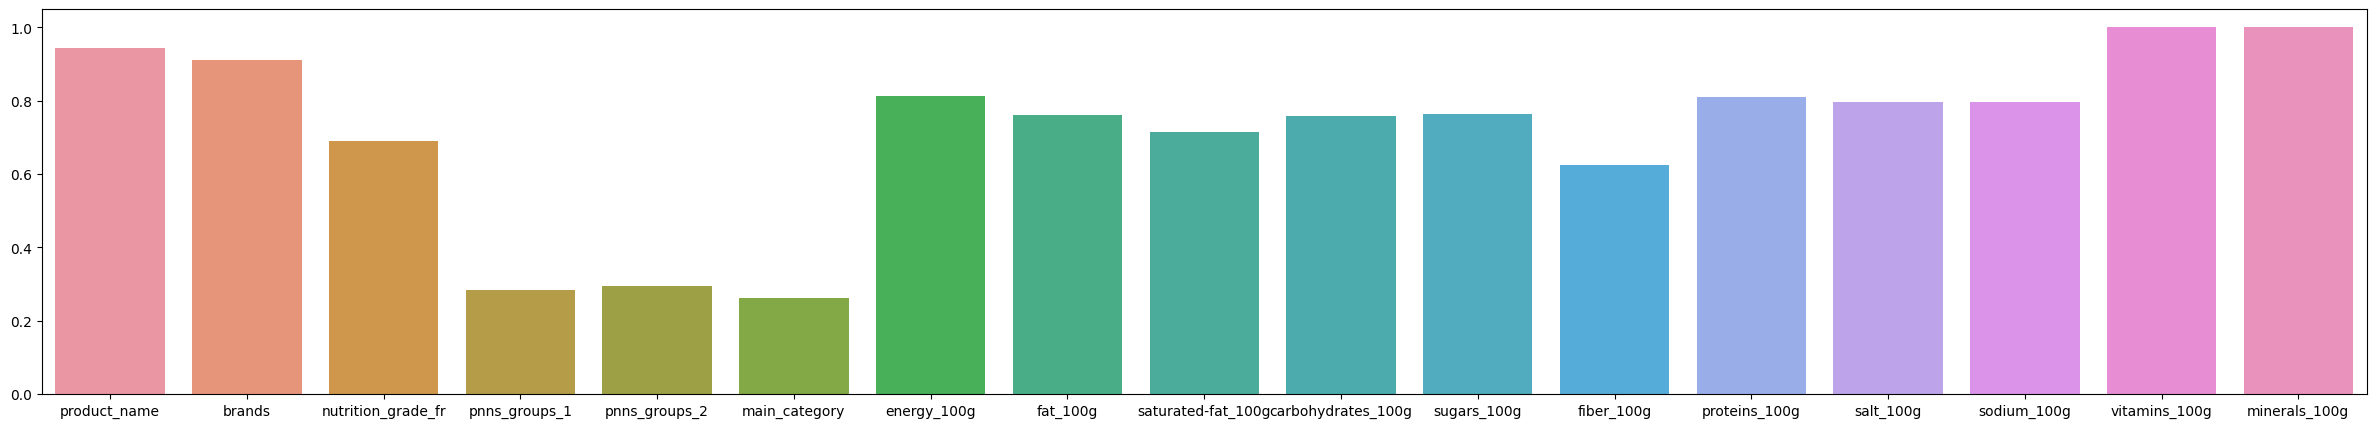

In [41]:
rcParams['figure.figsize'] = (30,5)
data = pd.DataFrame(products.notna().mean()).T
sns.barplot(data)

#### Traitement des valeurs aberrantes

Faisons maintenant un peu de nettoyage au niveau des valeurs aberrantes et  manquantes, déjà on peut considérer que les produits où le nom du produit n'est pas exploitable ne vont pas nous servir.

In [530]:
#On retire déjà les valeurs manquantes pour le nom de produit
products.drop(products.loc[products['product_name'].isna()].index, inplace=True)#17762 lignes
products.reset_index(drop=True,inplace=True)

#On remarque aussi que certains produits ont des noms avec des caractères chinois ou gaëliques, voire des chiffres pour certains, on retire donc également ces produits.
products['symbole'] = products['product_name'].apply(lambda x : bool(re.match('^(?=.*[a-zA-Z])', x)))
products.loc[products['symbole']==False]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,main_category,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g,symbole
189,เล็บมือนาง (ตีนไก่ ),Thai import,NaN,unknown,unknown,en:chicken-feet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False
569,,M&S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False
4347,"1,2,",1 2,e,NaN,NaN,NaN,1941.0,14.29,7.14,75.0,21.43,0.0,7.14,0.72644,0.286,0.0,0.0,False
6571,うどん,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False
10148,عصيرغازي,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302893,茱莉牛奶味小熊饼干,Julie's,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False
302911,倍乐思烘焙扁桃仁夹心牛奶巧克力120克,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False
302967,100 г очищенных жареных семечек,Семечек стакан,NaN,unknown,unknown,en:plant-based-foods-and-beverages,2970.0,65.00,NaN,6.0,NaN,NaN,26.00,NaN,NaN,0.0,0.0,False
302998,Лимон — лайм,Пеликан,NaN,Fruits and vegetables,Fruits,en:fruits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False


In [531]:
products.drop(products.loc[products['symbole']==False].index, inplace=True) #1435 lignes
products.drop('symbole', axis=1, inplace=True)
products.reset_index(drop=True,inplace=True)
products

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,main_category,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
0,Farine de blé noir,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000
1,Banana Chips Sweetened (Whole),NaN,d,NaN,NaN,NaN,2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000,0.0214,0.00129
2,Peanuts,Torn & Glasser,b,NaN,NaN,NaN,1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,0.0000,0.07229
3,Organic Salted Nut Mix,Grizzlies,d,NaN,NaN,NaN,2540.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482,0.0000,0.14814
4,Organic Polenta,Bob's Red Mill,NaN,NaN,NaN,NaN,1552.0,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN,0.0000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301570,Rillette d'oie,"Sans marque,D.Lambert",NaN,Fish Meat Eggs,Processed meat,en:salted-spreads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000
301571,Tomato & ricotta,Panzani,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000
301572,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",Trader Joe's,b,NaN,NaN,NaN,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00000,0.000,0.0000,0.00000
301573,Tomates aux Vermicelles,Knorr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000


De plus, chaque produit est identifié par son nom et sa marque, on peut donc retirer les doublons de notre dataset.

In [532]:
products.drop_duplicates(subset=['product_name','brands'],inplace=True,ignore_index=True) #20 503 lignes
products.reset_index(drop=True,inplace=True)

In [533]:
products

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,main_category,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
0,Farine de blé noir,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000
1,Banana Chips Sweetened (Whole),NaN,d,NaN,NaN,NaN,2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000,0.0214,0.00129
2,Peanuts,Torn & Glasser,b,NaN,NaN,NaN,1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,0.0000,0.07229
3,Organic Salted Nut Mix,Grizzlies,d,NaN,NaN,NaN,2540.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482,0.0000,0.14814
4,Organic Polenta,Bob's Red Mill,NaN,NaN,NaN,NaN,1552.0,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN,0.0000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281067,Rillette d'oie,"Sans marque,D.Lambert",NaN,Fish Meat Eggs,Processed meat,en:salted-spreads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000
281068,Tomato & ricotta,Panzani,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000
281069,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",Trader Joe's,b,NaN,NaN,NaN,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00000,0.000,0.0000,0.00000
281070,Tomates aux Vermicelles,Knorr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000


Tout d'abord on peut voir que dans la variable 'main_category', on a des produits non-alimentaires dont on va pouvoir se débarasser. Cette variable ne nous est par la suite plus utile car elle est redondante avec les groupes pnnns et moins exploitable.

In [534]:
non_alim = products.loc[products['main_category']=='en:non-food-products'] #99 lignes
products.drop(non_alim.index, inplace=True)
products.drop('main_category',axis=1, inplace=True)
products.reset_index(drop=True,inplace=True)

On va maintenant s'intéresser aux valeurs aberrantes présentes dans le dataset. Toutes nos variables nutritionelles donnent une valeur sur un échantillon de 100g, ainsi toute valeur au-dessus de 100 pour ces variables (sauf pour l'énergie) sera forcément une valeur aberrante. De plus une valeur négative n'est également pas possible. Concernant les valeurs aberrantes pour l'énergie, on s'y attardera plus tard.

Ensuite, on a également d'autres valeurs aberrantes dûes au fait qu'on a des variables "principales" et des variables "secondaires". En effet, les gras saturés, les sucres, les fibres et le sodium sont toutes des variables secondaires respectivement du gras, des carbohydrates et du sel. C'est donc impossible d'avoir une valeur dans une des ces variables qui soit supérieure à celle de sa variable principale.

In [535]:
variables =['fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g',
            'sodium_100g','minerals_100g', 'vitamins_100g']

#On regarde déjà les lignes où on a des valeurs négatives
for var in variables :
    display(products.loc[products[var]<0])

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
7552,Grade A Fancy Chopped Spinach,Spartan,a,NaN,NaN,151.0,0.00,0.00,3.61,-1.20,1.2,2.41,0.38354,0.151000,0.002304,0.09687
16235,"Select, Spicy Red Bell Pepper Pasta Sauce",Signature,b,NaN,NaN,167.0,0.80,0.00,7.20,-0.80,0.8,0.80,0.87376,0.344000,0.000000,0.00000
105297,"Hummous, Black Truffle",The Wild Pea,a,NaN,NaN,598.0,3.57,0.00,21.43,-3.57,3.6,7.14,0.95250,0.375000,0.008600,0.07229
131461,Crackers,Partners A Tasteful Choice Company,NaN,NaN,NaN,1674.0,13.33,3.33,66.67,-6.67,6.7,NaN,2.03200,0.800000,0.000000,0.00240
135730,"Italianavera, Tomato Sauce With Gaeta Olives &...",Italiana Vera Srl,c,NaN,NaN,326.0,6.25,1.25,5.00,-6.25,1.2,1.25,1.19380,0.470000,0.018187,0.05090
147868,Organic Pumpkin Seeds,Cb's Nuts,a,NaN,NaN,255.0,21.43,3.57,53.57,-17.86,17.9,17.86,1.93294,0.761000,0.000000,0.07421
175798,Caprice des dieux,Caprice des Dieux,d,Milk and dairy products,Cheese,1379.0,30.00,21.00,0.80,-0.10,NaN,15.30,1.40000,0.551181,0.000000,0.35000


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
21331,Traditional Tender Cracklins Chicharrones,Baken-Ets,NaN,NaN,NaN,2230.0,33.33,13.33,0.0,0.0,-6.7,NaN,6.43382,2.533,0.0,0.0


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
103163,"Gourmet Blends, Seasoning, Garlic Pepper",Spice Islands,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,-500.0,25.40,10.0,0.0,0.0
152599,Lightly Dried Cilantro,Gourmet Garden,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,-800.0,7.62,3.0,0.0,0.0


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
37264,Cheez Waffies,Wise,e,NaN,NaN,2092.0,28.57,21.43,50.0,17.86,0.0,7.14,2.72034,1.071,-0.00210,0.14429
71971,"Flavor Aid, Soft Drink Mix, Lemon",The Jel Sert Co.,NaN,NaN,NaN,0.0,0.00,NaN,0.0,NaN,NaN,0.00,0.00000,0.000,-0.00034,0.00000


In [536]:
for var in variables :
    display(products.loc[products[var]>100])

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
100982,Premium Extra Virgin Olive Oil,Eliki,e,NaN,NaN,110579.0,714.29,100.0,NaN,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
220800,mini choux goût fromage de chèvre - poivre,Auchan,e,Salty snacks,Appetizers,18700.0,380.00,210.0,190.0,22.7,0.0,0.0,9.33,3.670000,0.0,0.0
266729,Ekstra Jomfru Olivenolie,Santagata,d,Fat and sauces,Fats,3737.0,101.00,15.0,0.0,0.0,NaN,0.0,0.00,0.000000,0.0,0.0
268322,Graine de couscous moyen,La méditerranéa,a,Cereals and potatoes,Cereals,1482.0,105.00,0.3,70.0,2.5,NaN,12.0,0.01,0.003937,0.0,0.0


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
106818,"Raw 100% Cacao, With Bits Of Delicate Dates",Antidote,NaN,NaN,NaN,8523.0,NaN,175.38,80.0,NaN,15.4,33.85,0.11684,0.046,0.0,0.09588
220800,mini choux goût fromage de chèvre - poivre,Auchan,e,Salty snacks,Appetizers,18700.0,380.0,210.00,190.0,22.7,0.0,0.00,9.33000,3.670,0.0,0.00000
275501,"Nusco, Chocolate Spread, Chocolate",Brinkers,e,NaN,NaN,231199.0,NaN,550.00,NaN,3520.0,5380.0,430.00,0.01016,0.004,0.0,0.00000


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
63462,"Toaster Pastries, Strawberry",Winco Foods,e,NaN,NaN,2615.0,NaN,6.25,209.38,46.88,3.1,6.250,1.50876,0.594000,0.000469,0.00000
107180,Naturally Caffeinated Pure Empower Mint Dietar...,Guayaki,NaN,NaN,NaN,837.0,NaN,NaN,120.00,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000
119853,Mango Jalapeno,California Flavored Nuts,NaN,NaN,NaN,1941.0,0.0,0.00,125.00,110.71,7.1,NaN,NaN,NaN,0.001071,0.07229
140112,Beurre d'érable,NaN,NaN,unknown,unknown,1390.0,0.0,0.00,164.00,72.70,NaN,0.000,NaN,NaN,0.000000,0.33360
140265,"Tamarind Juice With Nata De Coco, Tamarind",Kelly Jelly,NaN,NaN,NaN,NaN,0.0,NaN,2916.67,166.67,250.0,NaN,147.32000,58.000000,0.000000,0.00000
181895,Sirop d'Agave brun bio,Bjorg,d,unknown,unknown,1760.0,0.0,0.00,104.00,104.00,0.0,0.000,0.14000,0.055100,0.000000,0.00000
211209,Palets pur beurre,Georges Blanc,e,Sugary snacks,Biscuits and cakes,3925.0,52.0,35.50,106.00,52.00,3.0,10.000,1.30048,0.512000,0.000200,0.00100
215316,Sirop d'agave,Carrefour Bio,NaN,Sugary snacks,Sweets,1785.0,NaN,NaN,105.00,105.00,NaN,NaN,NaN,NaN,0.000000,0.00000
220800,mini choux goût fromage de chèvre - poivre,Auchan,e,Salty snacks,Appetizers,18700.0,380.0,210.00,190.00,22.70,0.0,0.000,9.33000,3.670000,0.000000,0.00000
234049,Agave Syrup dark,Allos,d,unknown,unknown,1760.0,1.0,1.00,103.50,103.50,NaN,1.000,0.10000,0.039370,0.000000,0.00000


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
119853,Mango Jalapeno,California Flavored Nuts,NaN,NaN,NaN,1941.0,0.0,0.0,125.00,110.71,7.1,NaN,NaN,NaN,0.001071,0.07229
140265,"Tamarind Juice With Nata De Coco, Tamarind",Kelly Jelly,NaN,NaN,NaN,NaN,0.0,NaN,2916.67,166.67,250.0,NaN,147.32000,58.00000,0.000000,0.00000
181895,Sirop d'Agave brun bio,Bjorg,d,unknown,unknown,1760.0,0.0,0.0,104.00,104.00,0.0,0.000,0.14000,0.05510,0.000000,0.00000
215316,Sirop d'agave,Carrefour Bio,NaN,Sugary snacks,Sweets,1785.0,NaN,NaN,105.00,105.00,NaN,NaN,NaN,NaN,0.000000,0.00000
234049,Agave Syrup dark,Allos,d,unknown,unknown,1760.0,1.0,1.0,103.50,103.50,NaN,1.000,0.10000,0.03937,0.000000,0.00000
234050,Sirop d agave pur,Allos,d,unknown,unknown,1760.0,1.0,0.1,103.50,103.50,NaN,1.000,0.10000,0.03937,0.000000,0.00000
234060,Agavendicksaft,Allos,d,unknown,unknown,1760.0,1.0,0.1,103.50,103.50,NaN,1.000,0.10000,0.03937,0.000000,0.00000
237835,Agavendicksaft,enerBIO,d,unknown,unknown,1760.0,1.0,0.1,103.50,103.50,NaN,1.000,0.10000,0.03937,0.000000,0.00000
237837,Agavendicksaft Dunkel,ener Bio,NaN,unknown,unknown,1756.0,0.1,0.0,103.00,103.00,0.1,0.013,NaN,NaN,0.000000,0.00000
275501,"Nusco, Chocolate Spread, Chocolate",Brinkers,e,NaN,NaN,231199.0,NaN,550.0,NaN,3520.00,5380.0,430.000,0.01016,0.00400,0.000000,0.00000


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
57512,"Chef Merito, Creole Style Adobo",Chef Merito Inc.,NaN,NaN,NaN,699.0,NaN,NaN,NaN,NaN,166.7,11.67,73.02500,28.750000,0.01,0.0
140265,"Tamarind Juice With Nata De Coco, Tamarind",Kelly Jelly,NaN,NaN,NaN,NaN,0.0,NaN,2916.67,166.67,250.0,NaN,147.32000,58.000000,0.00,0.0
263317,Milka Schmunzelhase Alpenmilch 175G,Mondelez,e,unknown,unknown,2218.0,29.0,18.0,59.00,58.00,178.0,6.30,0.37000,0.145669,0.00,0.0
275501,"Nusco, Chocolate Spread, Chocolate",Brinkers,e,NaN,NaN,231199.0,NaN,550.0,NaN,3520.00,5380.0,430.00,0.01016,0.004000,0.00,0.0


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
275501,"Nusco, Chocolate Spread, Chocolate",Brinkers,e,NaN,NaN,231199.0,NaN,550.0,NaN,3520.0,5380.0,430.0,0.01016,0.004,0.0,0.0


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
458,Mediterranean Sea Salt,Olde Thompson,NaN,NaN,NaN,0.0,0.00,NaN,0.00,NaN,NaN,0.00,105.83418,41.667000,0.0000,0.00000
1238,Dill Pickle Cashews,Emerald,e,NaN,NaN,2389.0,45.71,8.57,28.57,5.71,5.7,17.14,870.85678,342.857000,0.0000,0.00617
3104,Coarse Kosher Salt,Kroger,NaN,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.00,101.60000,40.000000,0.0000,0.00000
6275,Fine Sea Salt,Shurfine,NaN,NaN,NaN,0.0,0.00,NaN,0.00,NaN,NaN,0.00,101.60000,40.000000,0.0000,0.00000
7098,Butter Beans,Spartan,c,NaN,NaN,322.0,0.77,0.00,12.31,2.31,3.8,4.62,781.53768,307.692000,0.0000,0.37038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244555,Cheese salad,NaN,d,Composite foods,Sandwich,348.0,4.70,4.80,0.30,0.40,0.1,3.60,297.60000,117.165354,0.0000,0.00000
248641,Organic Dill Salt,Aromasong,c,NaN,NaN,0.0,0.00,0.00,0.00,0.00,0.0,0.00,100.51034,39.571000,0.0000,0.00000
252145,Bamboo Shoots,Slender,c,NaN,NaN,50.0,0.00,0.00,3.53,0.00,3.5,2.35,448.23634,176.471000,0.0014,0.00127
262635,Kids Cristal,Aproz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,930.00000,366.141732,0.0000,0.43000


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
1238,Dill Pickle Cashews,Emerald,e,NaN,NaN,2389.0,45.71,8.57,28.57,5.71,5.7,17.14,870.85678,342.857000,0.000000,0.00617
7098,Butter Beans,Spartan,c,NaN,NaN,322.0,0.77,0.00,12.31,2.31,3.8,4.62,781.53768,307.692000,0.000000,0.37038
9860,Autumn Cookie Selection,Caldo International Inc.,e,NaN,NaN,2025.0,30.65,2.42,48.39,22.58,1.6,4.84,327.74128,129.032000,0.000048,0.03432
18635,"Special Blend, Peas & Carrots",Del Monte,c,NaN,NaN,197.0,0.00,0.00,10.16,3.12,3.1,2.34,714.37500,281.250000,0.005638,0.17284
19605,"Marie Sharp's, Orange Pulp Habanero Pepper Sau...",Melinda's Limited,e,NaN,NaN,2008.0,0.00,0.00,90.00,44.00,34.0,14.00,594.86800,234.200000,0.050700,0.00817
21159,Original Barbecue Sauce,Billy Sims Barbecue,c,NaN,NaN,628.0,0.00,0.00,36.67,16.67,3.3,0.00,2032.00000,800.000000,0.004100,0.00120
45839,"Crispy Fried Onions, White Cheddar",French's,NaN,NaN,NaN,2690.0,50.00,21.43,42.86,NaN,NaN,0.00,2177.14322,857.143000,0.000000,0.00000
51741,String Cheese Snacks,Sargento,e,NaN,NaN,1222.0,18.75,12.50,4.17,0.00,0.0,25.00,1799.16582,708.333000,0.000250,0.62500
61095,"Rhodes, Bake N Serv, Cinnamon Rolls With Cream...",Rhodes Bake-N-Serv,d,NaN,NaN,1243.0,8.11,2.70,48.65,9.46,1.4,5.41,1098.37728,432.432000,0.000000,0.05643
61103,"Rhodes, Bake N Serv, Cinnamon Rolls With Cream...",Rhodes Bake-N-Serv,d,NaN,NaN,1238.0,7.04,2.11,50.70,11.27,1.4,5.63,858.59112,338.028000,0.000000,0.03054


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g


,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g


On voit que ça représente peu de produits, mais les valeurs sont généralement très aberrantes et vont poser des problèmes lors de l'analyse.

In [537]:
#On replace toutes ces valeurs aberrantes par des NaN qu'on essayera de remplir plus tard
for var in variables :
    products = products.mask(products[var]<0, products.assign(**{var: np.nan}))
    products = products.mask(products[variables]>100, products.assign(**{var: np.nan}))

On a pris une valeur de 100 car c'était la limite pour les 100g, mais dans le cas du sodium, il ne peut pas dépasser 40 car ils provient du sel et le sel est composé à 40% de sodium.

In [538]:
products = products.mask(products['sodium_100g']>40, products.assign(**{'sodium_100g': np.nan}))

In [539]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280976 entries, 0 to 280975
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   product_name        280976 non-null  object 
 1   brands              269211 non-null  object 
 2   nutrition_grade_fr  203505 non-null  object 
 3   pnns_groups_1       83703 non-null   object 
 4   pnns_groups_2       86369 non-null   object 
 5   energy_100g         238340 non-null  float64
 6   fat_100g            221771 non-null  float64
 7   saturated-fat_100g  210835 non-null  float64
 8   carbohydrates_100g  221443 non-null  float64
 9   sugars_100g         224537 non-null  float64
 10  fiber_100g          184621 non-null  float64
 11  proteins_100g       237333 non-null  float64
 12  salt_100g           233854 non-null  float64
 13  sodium_100g         233857 non-null  float64
 14  vitamins_100g       280974 non-null  float64
 15  minerals_100g       280976 non-nul

On a 2 cas de figures pour les comparaisons entre variable principale est secondaire.
Si la secondaire > principale, alors on remplace la valeur dans la variable secondaire par un NaN.
Cependant, si la variable principale est vide et la secondaire est remplie, cela n'apparaît pas dans notre comparaison.On essayera donc de remplir ces valeurs plus tard, puis on refera un tri de valeurs aberrantes à la fin.

In [540]:
#On regarde les produits où sugar > carbohydrates
products.loc[products['sugars_100g']>products['carbohydrates_100g']] #674 lignes

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
355,Dried Honey Crisp Apples,Welch's,c,NaN,NaN,1255.0,0.00,0.00,72.50,75.00,7.5,0.00,0.00000,0.0000,0.000000,0.00000
1302,"Muchacha, Salsa, Mild",Penguin Software Inc,c,NaN,NaN,297.0,5.36,0.00,3.57,7.14,0.0,0.00,0.68072,0.2680,0.013114,0.00129
1303,"Muchacha, Medium Salsa",Penguin Software Inc,c,NaN,NaN,297.0,5.36,0.00,3.57,7.14,0.0,0.00,0.68072,0.2680,0.013114,0.00129
1304,"Muchacho, Hot Salsa, Hot",Penguin Software Inc,c,NaN,NaN,297.0,5.36,0.00,3.57,7.14,0.0,0.00,0.68072,0.2680,0.013114,0.00129
1845,Creamy Tomato Bisque,Wholesome@Home,c,NaN,NaN,460.0,8.98,4.08,5.71,6.12,1.2,1.63,0.73660,0.2900,0.006192,0.01629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278749,"Sambal Kecap Sweet Soy Chili Sauce, Hot",Cap Ibu Mother Brand,e,NaN,NaN,1674.0,30.00,0.00,20.00,80.00,30.0,20.00,3.73380,1.4700,0.000000,0.00000
279641,Deep Spring Orange & Passionfruit,"Deep Spring,Coca-Cola Amatil",a,Beverages,Sweetened beverages,38.4,0.40,0.00,2.00,2.16,NaN,0.40,0.00965,0.0038,0.000000,0.00000
280447,"Hank's, Jam, Raspberry",Hank's Brands Pty Ltd.,d,NaN,NaN,849.0,0.00,0.00,46.80,62.40,NaN,2.00,0.02032,0.0080,0.000000,0.00000
280492,Organic Lightly Sparkling Blood Orange,Parker's,b,NaN,NaN,155.0,0.00,0.00,8.48,9.09,0.6,0.61,0.01524,0.0060,0.000000,0.00000


In [541]:
products = products.mask(products['sugars_100g']>products['carbohydrates_100g'], products.assign(**{'sugars_100g': np.nan}))

De même, les fibres font parties des carbohydrates, donc on vérifie la même condition.

In [542]:
products.loc[(products['fiber_100g'])>(products['carbohydrates_100g']+0.2)] #1882 lignes
#On peut voir que pour de nombreuses lignes(~500), la différence entre fibres et carbs est d'à peine 0.1, sûrement à cause 
# d'un arrondissement, donc on rajoute une marge de 0.2 afin de garder ces valeurs qui ne sont pas réellement aberrantes.
# On remplace cependant ces valeurs proches par la valeur exacte afin de ne pas avoir de valeurs aberrantes

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
2811,Roasted Seaweed Snack,The Kroger Co.,d,NaN,NaN,2510.0,40.00,0.00,0.00,0.00,20.0,20.00,2.54000,1.000000,0.0015,0.00720
4646,16 Bean Soup Mix,Roundy's,a,NaN,NaN,883.0,0.00,0.00,7.89,2.63,34.2,21.05,0.53594,0.211000,0.0000,0.10784
5681,Almonds Roasted & Salted,Roundy's,c,NaN,NaN,2510.0,54.29,4.29,0.00,NaN,11.4,20.00,0.87122,0.343000,0.0000,0.26111
10154,Taco Seasoning,"Whole Foods Market, Allegro Coffee Company",c,NaN,NaN,71.0,0.00,0.00,0.00,0.00,3.3,0.00,3.04800,1.200000,0.0044,0.00240
10535,Spice Paste for Indian Butter Chicken Murgh Ma...,Asian Home Gourmet,c,unknown,unknown,837.0,15.90,2.40,6.30,6.20,7.7,8.30,8.69950,3.425000,0.0000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280291,SF Health Foods Psyllium Husk,"SF Health Foods,SF Health Foods Psyllium Husk",a,unknown,unknown,802.0,3.00,0.00,0.00,0.00,80.0,3.00,0.20066,0.079000,0.0000,0.00000
280408,Freshlife Australian almond meal,Freshlife,b,unknown,unknown,2530.0,20.00,3.60,4.40,4.40,8.8,20.00,0.01270,0.005000,0.0000,0.00000
280532,Ultra low carb choc mocha delight,bodytrim,d,unknown,unknown,1530.0,13.30,9.70,2.80,1.00,13.1,28.40,0.80010,0.315000,0.0000,0.00000
280581,Spaghetti konjac,Slendier,a,unknown,unknown,33.0,0.00,0.00,0.00,0.00,5.0,1.00,0.00000,0.000000,0.0000,0.00000


In [543]:
products = products.mask(products['fiber_100g']>products['carbohydrates_100g']+0.2, products.assign(**{'fiber_100g': np.nan}))
products = products.mask(products['fiber_100g']>products['carbohydrates_100g'], products.assign(**{'fiber_100g': products['carbohydrates_100g']}))

De même pour les 'fats' et 'saturated fats'

In [544]:
products.loc[products['saturated-fat_100g']>products['fat_100g']] #337 lignes

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
2082,Dried Cranberries,"Simple Truth Organic, The Kroger Co.",c,NaN,NaN,1255.0,0.00,1.25,82.50,65.00,5.0,0.00,0.00000,0.000000,0.000000,0.00045
3082,"Parfait, Strawberry, Orange, Grape",Psst,NaN,NaN,NaN,NaN,1.31,1.62,0.00,NaN,NaN,NaN,0.06096,0.024000,0.000000,0.00000
5178,Iced Brownies,Roundy's,e,NaN,NaN,1322.0,9.21,21.05,60.53,47.37,2.6,2.63,0.43434,0.171000,0.000000,0.00189
5179,Easter Pink Frosted Brownies,Roundy's,e,NaN,NaN,1322.0,9.21,21.05,60.53,47.37,2.6,2.63,0.43434,0.171000,0.000000,0.00189
5619,Tzatziki Sauce,Roundy's,c,NaN,NaN,448.0,1.79,5.36,7.14,0.00,0.0,3.57,1.04394,0.411000,0.004407,0.14300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278207,Crème De Coco Uht AROY-D 1L,"Aroy d, Thai Agri Foods Public Company Limited",d,NaN,NaN,774.0,18.89,19.00,2.22,NaN,0.0,16.00,0.05000,0.019685,0.000000,0.00000
278301,sweet sour sauce thai pride,thai pride,NaN,Fat and sauces,Dressings and sauces,194.0,0.00,2.00,11.00,8.50,NaN,NaN,0.75438,0.297000,0.000000,0.00000
278500,Mahi Burgers,Caribbean,c,NaN,NaN,368.0,0.88,4.42,5.31,1.77,0.0,15.93,0.89916,0.354000,0.018679,0.01927
278679,Bot Rieng Galangal Powder,Peacock Brand,c,NaN,NaN,1674.0,0.00,20.00,40.00,0.00,20.0,0.00,0.00000,0.000000,0.000000,0.00000


In [545]:
products = products.mask(products['saturated-fat_100g']>products['fat_100g'], products.assign(**{'saturated-fat_100g': np.nan}))

De même pour le sel et le sodium

In [546]:
products.loc[products['sodium_100g']>products['salt_100g']]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g


On a maintenant enelevé les valeurs aberrantes "évidentes", cependant il peut y avoir d'autres valeurs aberrantes qui n'aparaissent pas dans notre tri. En effet une ligne pourrait avoir toutes ses variables avec des valeurs de 90 ce qui serait aberrant mais pas détecté ici. Ce qu'on peut faire c'est donc additionner les valeurs de 'fat', 'carbohydrates', 'salt' et 'proteins' et vérifier qu'on arrive proche de 100. On laisse cependant un peu de marge d'erreurs en cas d'imprécisions.

In [547]:
#On applique un fillna(0) dans la somme pour ne pas que la somme devienne NaN en cas de valeur manquante
drops = products.loc[(products['fat_100g'].fillna(0) + products['carbohydrates_100g'].fillna(0) + products['proteins_100g'].fillna(0) + products['salt_100g'].fillna(0))>=110].index
products.loc[(products['fat_100g'].fillna(0) + products['carbohydrates_100g'].fillna(0) + products['proteins_100g'].fillna(0) + products['salt_100g'].fillna(0))>=110]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
73,Organic Whole Brown Rice Flour,Fairhaven,NaN,NaN,NaN,1891.0,3.23,NaN,96.77,NaN,6.4,12.90,NaN,NaN,0.000000,0.00232
133,Organic Arboria Rice,Lundberg,NaN,NaN,NaN,1490.0,2.22,NaN,95.56,NaN,2.2,13.33,NaN,NaN,0.000000,0.00000
214,Chocolate Scone,Fresh & Easy,e,NaN,NaN,2912.0,39.29,23.21,80.36,46.43,3.6,5.36,0.63500,0.250,0.000107,0.07357
237,"Herbal Tea, Hibiscus",Lagg's,NaN,NaN,NaN,1117.0,0.00,NaN,60.00,NaN,NaN,66.67,0.33782,0.133,0.000000,0.00000
238,Apple & Cinnamon Tea,Lagg's,NaN,NaN,NaN,0.0,0.00,NaN,60.00,NaN,NaN,66.67,0.33782,0.133,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277902,Seaweed Snack,Golden Natural,d,NaN,NaN,2510.0,32.00,0.00,40.00,0.00,40.0,40.00,3.81000,1.500,0.009000,0.41440
278051,Yellow Curry Paste,Mae Ploy,NaN,NaN,NaN,699.0,100.00,0.00,22.22,0.00,5.6,NaN,5.22224,2.056,0.000000,0.00000
278356,Broccoli Chips,Smile Fruit Co Ltd,c,NaN,NaN,1987.0,20.00,5.00,90.00,30.00,15.0,5.00,0.00000,0.000,0.030375,0.60180
278357,Cherry Tomato Chips,Smile Fruit Co. Ltd,d,NaN,NaN,1883.0,20.00,5.00,90.00,40.00,15.0,5.00,0.00000,0.000,0.015600,0.10180


In [548]:
products.drop(drops, inplace=True)  #643 lignes
products.reset_index(drop=True,inplace=True)

In [549]:
#On pourrait aussi regarder les lignes qui n'ont que très peu de quantité renseignées
products.loc[(products['fat_100g'] + products['carbohydrates_100g'] + products['proteins_100g'] + products['salt_100g'])<50]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
170,Fresh Organic Carrots,Bunny-Luv,a,NaN,NaN,159.0,0.00,0.00,8.97,6.410,2.600,1.28,0.19558,0.077000,0.009815,0.026460
181,Quiche Lorraine,Kirkland Signature,b,Composite foods,Pizza pies and quiche,478.0,6.79,2.86,7.86,0.714,0.357,5.36,0.49900,0.196000,0.000440,0.029243
216,"Pepsi, Nouveau goût !",Pepsi,e,Beverages,Sweetened beverages,177.0,0.00,0.00,10.40,10.400,0.000,0.00,0.02540,0.010000,0.000000,0.000000
217,Naturally Flavored Beverage Enhancer With Othe...,Easter Unlimited Inc.,NaN,NaN,NaN,0.0,0.00,NaN,0.00,0.000,NaN,0.00,2.38252,0.938000,0.000000,0.000000
224,Cauliflower,"Sainsbury's,by sainsbury's",NaN,Fruits and vegetables,Vegetables,144.0,0.90,NaN,2.90,2.500,1.800,3.60,0.00000,0.000000,0.043000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280319,Raspados Ice Bars,"Jarritos, The Jel Sert Company",NaN,NaN,NaN,368.0,0.00,NaN,21.05,19.300,NaN,0.00,0.04572,0.018000,0.000000,0.000000
280321,Test NF App,NaN,NaN,NaN,NaN,569.0,31.00,NaN,12.20,9.600,1.100,2.10,1.10000,0.433071,0.000000,0.000000
280326,Thé vert Earl grey,Lobodis,c,Beverages,Non-sugared beverages,21.0,0.20,0.20,0.50,0.500,0.200,0.50,0.02540,0.010000,0.000000,0.000000
280330,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",Trader Joe's,b,NaN,NaN,0.0,0.00,0.00,0.00,0.000,0.000,0.00,0.00000,0.000000,0.000000,0.000000


On voit que même en prenant une limite à 50 cela représente un nombre de lignes très conséquents, car certains produits sont constitués d'eau ou d'autre élements pas renseignés ici, mais également à cause de valeurs manquantes qu'on va maintenant traiter. Pour cela on va par tout d'abord regrouper les valeurs par catégories afin de leur imputer des valeurs avec des produits proches. Cependant de nombreux produits ne possèdent pas non plus de catégorie donc on va devoir trouver d'autres solutions pour ces cas là.
D'autre part, on a beaucoup de valeurs manquantes sur les valeurs en vitamines et minéraux, car de nombreux produits ne possèdent pas ces éléments, ou en quantité vraiment négligeable, on peut donc les imputer par 0.

On note également que dans les variables pnns_groups, on a des valeurs manquantes et des valeurs 'unknown', ce qui correspond à la même chose donc par uniformité on va remplacer les unknown par des NaN, et on y reviendra plus tard pour essayer de les remplir.

In [550]:
products.loc[products['pnns_groups_1']=='unknown','pnns_groups_1'] = np.nan
products.loc[products['pnns_groups_2']=='unknown','pnns_groups_2'] = np.nan

In [551]:
products['pnns_groups_1'].unique()

array([nan, 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'fruits-and-vegetables',
       'Milk and dairy products', 'Salty snacks', 'sugary-snacks',
       'cereals-and-potatoes', 'salty-snacks'], dtype=object)

On voit qu'on a des catégories répétées à cause d'orthographes différentes, donc on va normaliser tout ça afin de regrouper au mieux les produits.

In [552]:
products.replace({'fruits-and-vegetables':'Fruits and vegetables', 'sugary-snacks':'Sugary snacks', 'cereals-and-potatoes':'Cereals and potatoes', 'salty-snacks':'Salty snacks'}, inplace=True)
products['pnns_groups_1'].unique()

array([nan, 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'Milk and dairy products',
       'Salty snacks'], dtype=object)

In [553]:
products['pnns_groups_2'].unique()

array([nan, 'Vegetables', 'Biscuits and cakes', 'Bread', 'Legumes',
       'Pizza pies and quiche', 'Meat', 'Non-sugared beverages', 'Sweets',
       'Sweetened beverages', 'Dressings and sauces', 'One-dish meals',
       'vegetables', 'Soups', 'Chocolate products', 'Fruits', 'Cereals',
       'Milk and yogurt', 'Fats', 'Cheese', 'Sandwich', 'Appetizers',
       'Nuts', 'Breakfast cereals', 'Artificially sweetened beverages',
       'Fruit juices', 'Eggs', 'Fish and seafood', 'Alcoholic beverages',
       'Ice cream', 'Processed meat', 'Potatoes', 'Dried fruits',
       'Dairy desserts', 'Fruit nectars', 'pastries', 'Tripe dishes',
       'fruits', 'Salty and fatty products', 'cereals', 'legumes', 'nuts'],
      dtype=object)

In [554]:
products.replace({'vegetables':'Vegetables','legumes':'Legumes','nuts':'Nuts','fruits':'Fruits','cereals':'Cereals','pastries':'Pastries'}, inplace=True)

In [555]:
products

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
0,Farine de blé noir,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000
1,Banana Chips Sweetened (Whole),NaN,d,NaN,NaN,2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000,0.0214,0.00129
2,Peanuts,Torn & Glasser,b,NaN,NaN,1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,0.0000,0.07229
3,Organic Salted Nut Mix,Grizzlies,d,NaN,NaN,2540.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482,0.0000,0.14814
4,Organic Polenta,Bob's Red Mill,NaN,NaN,NaN,1552.0,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN,0.0000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280328,Rillette d'oie,"Sans marque,D.Lambert",NaN,Fish Meat Eggs,Processed meat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000
280329,Tomato & ricotta,Panzani,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000
280330,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",Trader Joe's,b,NaN,NaN,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00000,0.000,0.0000,0.00000
280331,Tomates aux Vermicelles,Knorr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00000


On peut commencer par retirer les lignes qui n'ont quasiment aucune valeur remplie dans les variables nutritionelles, car on ne pourra pas leur imputer de nouvelles valeurs à partir de ça.
Avant cela, on va remplir les colonnes vitamines et mineraux, ceux qui n'ont pas de valeurs pouvant être imputés par 0.

In [556]:
products[['vitamins_100g', 'minerals_100g']] = products[['vitamins_100g', 'minerals_100g']].fillna(0)

In [557]:
#Avec tresh=3, et comme vitamines et minéraux sont tous remplis, on drop les lignes qui ne contiennent aucune valeur
products.dropna(thresh=3, subset=variables, inplace=True) #42258 lignes
products.reset_index(drop=True, inplace=True)

Avant d'essayer de remplir par imputation, on peut continuer à imputer quelques autres valeurs par d'autres moyens, en regardant des combinaisons de variables.

In [558]:
#Pour commencer, on peut regarder les lignes où on a une valeur de 0 sur la variable principale et pas de valeurs sur la variable secondaire
products.loc[(products.fat_100g == 0) & (products['saturated-fat_100g'].isna())]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
197,Naturally Flavored Beverage Enhancer With Othe...,Easter Unlimited Inc.,NaN,NaN,NaN,0.0,0.0,NaN,0.00,0.00,NaN,0.00,2.38252,0.938,0.000,0.000
203,Chamomile Herbal Tea,Lagg's,NaN,NaN,NaN,0.0,0.0,NaN,70.00,NaN,NaN,0.00,0.76200,0.300,0.000,0.000
204,"Herbal Tea, Peppermint",Lagg's,NaN,NaN,NaN,0.0,0.0,NaN,1.47,NaN,NaN,0.00,0.01016,0.004,0.000,0.020
205,Linden Flowers Tea,Lagg's,NaN,NaN,NaN,0.0,0.0,NaN,53.33,NaN,NaN,0.00,0.00000,0.000,0.000,0.000
206,Green Tea,Lagg's,NaN,NaN,NaN,0.0,0.0,NaN,2.67,NaN,NaN,0.00,0.00000,0.000,0.000,0.077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238701,Sauce pimentée à l'ail,"Yeo's,Yeo Hiap Seng (Malaysia) Bhd",NaN,Fat and sauces,Dressings and sauces,247.0,0.0,NaN,17.65,17.65,NaN,0.00,2.83972,1.118,0.000,0.000
238727,Balsamic Vinegar Of Modena Glaze,Monari Fererzoni,NaN,NaN,NaN,929.0,0.0,NaN,50.00,33.33,NaN,0.00,0.14224,0.056,0.000,0.000
238729,Taco Seasoning Mix,Mccormick & Company Inc.,NaN,NaN,NaN,1393.0,0.0,NaN,66.67,16.67,NaN,16.67,16.08582,6.333,0.001,0.000
238735,Raspados Ice Bars,"Jarritos, The Jel Sert Company",NaN,NaN,NaN,368.0,0.0,NaN,21.05,19.30,NaN,0.00,0.04572,0.018,0.000,0.000


In [559]:
#Sur ces lignes on peut imputer que la valeur en saturated fat est également nulle, donc on peut remplacer les NaN par des 0.
index = products.loc[(products.fat_100g == 0) & (products['saturated-fat_100g'].isna())].index # 23414 lignes
products.loc[index, 'saturated-fat_100g'] = 0

In [560]:
#On peut faire de même pour les fibres ou les sucres dans les carbohydrates.

index = products.loc[(products['carbohydrates_100g']==0) & (products['sugars_100g'].isna() | products['fiber_100g'].isna())].index #11 569 lignes
products.loc[index,['sugars_100g','fiber_100g']] = 0

In [561]:
#Et encore une fois avec les valeurs en sodium pour le sel

index = products.loc[(products['salt_100g']==0)& products['sodium_100g'].isna()].index #35 lignes
products.loc[index,'sodium_100g'] = 0

In [562]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238742 entries, 0 to 238741
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   product_name        238742 non-null  object 
 1   brands              235784 non-null  object 
 2   nutrition_grade_fr  202809 non-null  object 
 3   pnns_groups_1       52394 non-null   object 
 4   pnns_groups_2       52544 non-null   object 
 5   energy_100g         237397 non-null  float64
 6   fat_100g            221133 non-null  float64
 7   saturated-fat_100g  232238 non-null  float64
 8   carbohydrates_100g  220804 non-null  float64
 9   sugars_100g         230122 non-null  float64
 10  fiber_100g          193096 non-null  float64
 11  proteins_100g       236698 non-null  float64
 12  salt_100g           233221 non-null  float64
 13  sodium_100g         233259 non-null  float64
 14  vitamins_100g       238742 non-null  float64
 15  minerals_100g       238742 non-nul

On peut maintenant regarder les lignes qui présentent encore des valeurs manquantes, notamment celles où quasiment tout est absent à part une ou deux colonnes.

In [563]:
products.loc[(products['fat_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['proteins_100g'].isna()) & (products['salt_100g'].isna())]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
130619,"Chomperz Crunchy Seaweed Chips, Onion",Sea Snax,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.67,NaN,NaN,NaN,NaN,0.0,0.0
135924,Bacon Style Slices,"Quorn, Quorn Foods Inc.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,0.0,0.0
143750,Vodka sauce,Mia's Kitchen,NaN,NaN,NaN,80.0,NaN,NaN,NaN,2.40,0.80,NaN,NaN,NaN,0.0,0.0
148272,SARAY Premium FOUL MUDAMMAS Fava Beans,SARAY,NaN,NaN,NaN,309.0,NaN,NaN,NaN,0.92,5.13,NaN,NaN,NaN,0.0,0.0
154001,Quand le chat n'est pas là - Pinot Gris 2013,Domaine Rietsch,NaN,NaN,Alcoholic beverages,NaN,NaN,NaN,NaN,0.18,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222710,Huile Extra-Vierge De Noix Pressee A L'Ancienne,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
231999,Puleva Mañanas Ligeras,Puleva,NaN,NaN,NaN,NaN,NaN,1.1,NaN,4.80,NaN,NaN,NaN,NaN,0.0,0.0
232678,Mermelada de frambuesas &quot;La Vieja Fábrica...,"La Vieja Fábrica,//Propiedad de://,Grupo Ángel...",NaN,Sugary snacks,Sweets,NaN,NaN,NaN,NaN,50.00,NaN,NaN,NaN,NaN,0.0,0.0
232679,Mermelada de albaricoque,"La Vieja Fábrica, //Propiedad de://, Grupo Áng...",NaN,Sugary snacks,Sweets,NaN,NaN,NaN,NaN,55.00,NaN,NaN,NaN,NaN,0.0,0.0


On peut voir notamment en regardant cela pour notre 4 variables les plus importantes que ces quelques lignes ne possèdent des valeurs que pour une ou 2 variables, et il sera impossible d'imputer le reste à partir de cela, à part en prenant au cas par cas et en recherchant par rapport au nom de produit, mais cela prendrait bien trop de temps. De plus il n'y a que 87 lignes concernées donc cela ne représente pas une trop grosse perte de données.

In [564]:
products.drop(products.loc[(products['fat_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['proteins_100g'].isna()) & (products['salt_100g'].isna())].index, inplace=True)
products.reset_index(drop=True,inplace=True)

On peut maintenant regarder un par un en retirant une des variables pour voir ce qu'il nous reste.

In [565]:
products.loc[(products['fat_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['salt_100g'].isna())]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
17912,"Organic Fruit Yogurt Smoothie, Pineapple Orang...","Earth's Best, Sesame Workshop",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.420,NaN,NaN,0.012577,0.20830
44293,Pepperoni original,Mamma Cozzis,NaN,Composite foods,Pizza pies and quiche,586.0,NaN,NaN,NaN,NaN,NaN,6.000,NaN,NaN,0.000000,0.00036
55932,Zucchini fries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,2.000,NaN,NaN,0.002460,0.00036
67765,Pound Cake Minis,Jennies Gluten Free Bakery,NaN,NaN,NaN,1393.0,NaN,0.00,NaN,25.64,2.6,5.130,NaN,NaN,0.000154,0.00092
101672,Sloppy Joe Seasoning Mix,"Mrs Dash, Up Country Naturals Of Vermont Inc.",NaN,NaN,NaN,1393.0,NaN,0.00,NaN,44.44,NaN,6.670,NaN,NaN,0.053967,0.45200
132081,Columbia River Corn Chowder,Rill Foods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.970,NaN,NaN,0.001773,0.01104
153887,Blédine Multicéréales,"Blédina,Blédine,Danone",NaN,NaN,NaN,1677.0,NaN,NaN,NaN,NaN,NaN,7.500,NaN,NaN,0.000000,0.00000
154463,Ciego Montero Pineapple,Ciego Montero,NaN,NaN,NaN,238.0,NaN,NaN,NaN,11.30,NaN,0.000,NaN,NaN,0.005328,0.00000
159314,New Season Corn Kernels,"New Season,Aldi",NaN,NaN,NaN,282.0,NaN,NaN,NaN,6.30,NaN,2.300,NaN,NaN,0.000000,0.00000
161265,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137,NaN,NaN,0.000000,0.00000


En faisant cette fois un tri et en gardant les valeurs manquantes sauf pour les protéines, on peut voir que les lignes concernées ne sont remplies que pour la variable proteins_100g, et on va donc s'en débarasser également.

In [566]:
products.drop(products.loc[(products['fat_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['salt_100g'].isna())].index, inplace=True)
products.reset_index(drop=True,inplace=True)

In [567]:
products.loc[(products['fat_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['proteins_100g'].isna())]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
24,Real Salt Granular,Redmond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.156780,37.857000,0.0000,0.00000
67,Fine Sea Salt,Unfi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.905820,39.333000,0.0000,0.00000
22929,Ancient Sea Salt,Pure Himalayan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.745820,35.333000,0.0000,0.00000
37534,Soft Cream Cheese,Iga,NaN,NaN,NaN,1393.0,NaN,23.33,NaN,NaN,NaN,NaN,1.099820,0.433000,0.0003,0.00000
59005,Still Scottish mountain water,M&S,NaN,Beverages,Non-sugared beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003048,0.001200,0.0000,0.00520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236148,Magnum mini Double Caramel Double Chocolate,Miko,NaN,Milk and dairy products,Ice cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0000,0.00000
236469,Ekstra finkornet bordsalt med jod,Jozo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.800000,39.291339,0.0000,0.00000
237163,Eau Kulen Natural Drinking Water,eau Kulen,NaN,Beverages,Non-sugared beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018542,0.007300,0.0000,0.00598
237295,Black Canyon/Aura still water,"aura,Black Canyon",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.909320,0.358000,0.0000,0.00607


En regardant la variable sel, on a également des résultats, cependant il faut faire attention sur cela car des produits comme le sel, ou d'autres condiments ne possèdent que du sel et c'est normal, on va donc uniquement retirer les lignes où la quantité de sel est très faible. On a également des produits comme de l'eau ou des boissons pour le sport qui contiennent peu de sel mais beaucoup de minéraux par exemple, donc on souhaite les garder aussi.

In [568]:
products.loc[(products['fat_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['proteins_100g'].isna())]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
24,Real Salt Granular,Redmond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.156780,37.857000,0.0000,0.00000
67,Fine Sea Salt,Unfi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.905820,39.333000,0.0000,0.00000
22929,Ancient Sea Salt,Pure Himalayan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.745820,35.333000,0.0000,0.00000
37534,Soft Cream Cheese,Iga,NaN,NaN,NaN,1393.0,NaN,23.33,NaN,NaN,NaN,NaN,1.099820,0.433000,0.0003,0.00000
59005,Still Scottish mountain water,M&S,NaN,Beverages,Non-sugared beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003048,0.001200,0.0000,0.00520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236148,Magnum mini Double Caramel Double Chocolate,Miko,NaN,Milk and dairy products,Ice cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0000,0.00000
236469,Ekstra finkornet bordsalt med jod,Jozo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.800000,39.291339,0.0000,0.00000
237163,Eau Kulen Natural Drinking Water,eau Kulen,NaN,Beverages,Non-sugared beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018542,0.007300,0.0000,0.00598
237295,Black Canyon/Aura still water,"aura,Black Canyon",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.909320,0.358000,0.0000,0.00607


In [569]:
products.drop(products.loc[(products['fat_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['proteins_100g'].isna()) & ~((products['minerals_100g']>0) | (products['salt_100g']>15))].index, inplace=True)
products.reset_index(drop=True,inplace=True)

Maintenant qu'on a enlevé les lignes qui nous posaient problèmes, on va pouvoir remplir les valeurs manquantes par des 0 sur ces produits. En effet ce sont soit des boissons soit du sel donc les autres éléments sont nuls.

In [570]:
index = products.loc[(products['fat_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['proteins_100g'].isna())].index
products.loc[index,variables] = products.loc[index,variables].fillna(0)

In [571]:
products.loc[(products['salt_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['proteins_100g'].isna())]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
8,Organic Sunflower Oil,Napa Valley Naturals,NaN,NaN,NaN,3586.0,100.0,7.14,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
91,Organic Extra Virgin Olive Oil,Napa Valley Naturals,NaN,NaN,NaN,3586.0,100.0,14.29,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
93,Organic Canola Oil Refined,Spectrum,NaN,NaN,NaN,3586.0,100.0,7.14,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
155,Organic Unrefined Extra Virgin Coconut Oil,Aunt Patty,NaN,NaN,NaN,3586.0,100.0,85.71,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
13570,White Chicken In Water,Crider,NaN,NaN,NaN,448.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234232,2 steaks hachés pur bœuf Bio (15 % MG),Dia,NaN,Fish Meat Eggs,Meat,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
234543,"Fromage blanc Nature (3,2% MG)",Dia,NaN,Milk and dairy products,Cheese,NaN,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
234544,Tomme Noire des Pyrénées IGP (27 % MG),Dia,NaN,Milk and dairy products,Cheese,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
235469,Beurre fin non salé - Père Noël,D. van der Pol,NaN,Fat and sauces,Fats,NaN,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


De même en regardant la variable fat, les seules lignes qu'on devrait trouver seraient des huiles ou des produits comme le beurre, on va donc faire un tri en choisissant un minimum de gras et en enlevant les autres lignes.

In [572]:
products.loc[(products['salt_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['proteins_100g'].isna()) & (products['fat_100g']>60)]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
8,Organic Sunflower Oil,Napa Valley Naturals,NaN,NaN,NaN,3586.0,100.0,7.14,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
91,Organic Extra Virgin Olive Oil,Napa Valley Naturals,NaN,NaN,NaN,3586.0,100.0,14.29,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
93,Organic Canola Oil Refined,Spectrum,NaN,NaN,NaN,3586.0,100.0,7.14,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
155,Organic Unrefined Extra Virgin Coconut Oil,Aunt Patty,NaN,NaN,NaN,3586.0,100.0,85.71,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
17193,"Essentials, Savory Blend Flax & Hemp Oil Dieta...","Spectrum, Spectrum Essentials",NaN,NaN,NaN,3586.0,100.0,7.14,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230013,Olio di Sansa di Oliva,Sancolombano,NaN,NaN,NaN,3700.0,100.0,15.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
230644,olio d'oliva,Guiseppe Fois,NaN,Fat and sauces,Fats,3390.0,91.6,67.10,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
232415,Aceite refinado de girasol,Coaliment,NaN,Fat and sauces,Fats,3400.0,92.0,12.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
232877,Aceite de oliva virgen extra ecológico &quot;O...,"Oro de Génave,//Propiedad de://,Sierra de Géna...",NaN,Fat and sauces,Fats,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [573]:
products.drop(products.loc[(products['salt_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['proteins_100g'].isna()) & ~(products['fat_100g']>60)].index, inplace=True)
products.reset_index(drop=True,inplace=True)

products.loc[(products['salt_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['proteins_100g'].isna()) & (products['fat_100g']>60), variables] = products.loc[(products['salt_100g'].isna()) & (products['carbohydrates_100g'].isna()) & (products['proteins_100g'].isna()) & (products['fat_100g']>60), variables].fillna(0)

On pourrait enfin regarder le résultats en isolant les carbohydrates, mais cela ne donne pas très résultats très utiles donc on ne va pas s'en servir.

In [574]:
products.loc[(products['salt_100g']==100) | (products['carbohydrates_100g']==100) | (products['proteins_100g']==100) | (products['fat_100g']==100)]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
8,Organic Sunflower Oil,Napa Valley Naturals,NaN,NaN,NaN,3586.0,100.0,7.14,0.0,0.00,0.0,0.0,0.00000,0.000,0.0,0.00
35,"Sweeteners, Demerara Turbinado Sugar","Wholesome, Wholesome Sweeteners",NaN,NaN,NaN,1569.0,NaN,NaN,100.0,100.00,NaN,NaN,NaN,NaN,0.0,0.00
68,"Sweeteners, Organic Fair Trade Sugar","Wholesome, Wholesome Sweeteners",NaN,NaN,NaN,1569.0,NaN,NaN,100.0,100.00,NaN,NaN,NaN,NaN,0.0,0.00
91,Organic Extra Virgin Olive Oil,Napa Valley Naturals,NaN,NaN,NaN,3586.0,100.0,14.29,0.0,0.00,0.0,0.0,0.00000,0.000,0.0,0.00
93,Organic Canola Oil Refined,Spectrum,NaN,NaN,NaN,3586.0,100.0,7.14,0.0,0.00,0.0,0.0,0.00000,0.000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237838,Pure Icing Sugar,CSR,NaN,Sugary snacks,Sweets,1700.0,0.0,0.00,100.0,100.00,NaN,NaN,2.54000,1.000,0.0,0.00
237968,Lemon Coconut Oil,Coco Joy,NaN,NaN,NaN,3628.0,100.0,93.33,0.0,0.00,0.0,0.0,0.00000,0.000,0.0,0.00
237969,Coconut Oil,Coco Joy,NaN,NaN,NaN,3628.0,100.0,93.33,0.0,0.00,0.0,0.0,0.00000,0.000,0.0,0.00
238118,Jeenys Palm Sugar,Jeenys,d,NaN,NaN,1690.0,0.5,0.50,100.0,90.00,0.1,1.0,0.02286,0.009,0.0,0.00


On peut voir que sur ces lignes où on a déjà une valeur à 100, la colonne secondaire respective est en général remplie également, les NaN dans ces variables secondaires peuvent donc être imputés par des 0.

In [575]:
products.loc[(products['salt_100g']==100) | (products['carbohydrates_100g']==100) | (products['proteins_100g']==100) | (products['fat_100g']==100), variables] = products.loc[(products['salt_100g']==100) | (products['carbohydrates_100g']==100) | (products['proteins_100g']==100) | (products['fat_100g']==100), variables].fillna(0)

In [576]:
products.loc[(products['proteins_100g']>90) | (products['fat_100g']>90) | (products['carbohydrates_100g']>90) | (products['salt_100g']>90),variables]

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,minerals_100g,vitamins_100g
8,100.0,7.14,0.00,0.00,0.000,0.000,0.00000,0.000000,0.00,0.0000
24,0.0,0.00,0.00,0.00,0.000,0.000,96.15678,37.857000,0.00,0.0000
35,0.0,0.00,100.00,100.00,0.000,0.000,0.00000,0.000000,0.00,0.0000
67,0.0,0.00,0.00,0.00,0.000,0.000,99.90582,39.333000,0.00,0.0000
68,0.0,0.00,100.00,100.00,0.000,0.000,0.00000,0.000000,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...
238118,0.5,0.50,100.00,90.00,0.100,1.000,0.02286,0.009000,0.00,0.0000
238119,0.0,0.00,100.00,22.22,0.000,0.000,0.00000,0.000000,0.01,0.0000
238133,92.0,39.00,0.00,0.00,0.000,0.000,0.00000,0.000000,0.00,0.0191
238142,1.3,1.28,95.87,0.12,0.005,0.040,0.00500,0.001969,0.00,0.0000


In [577]:
products.loc[(products['proteins_100g']>90) | (products['fat_100g']>90) | (products['carbohydrates_100g']>90) | (products['salt_100g']>90),variables]=products.loc[(products['proteins_100g']>90) | (products['fat_100g']>90) | (products['carbohydrates_100g']>90) | (products['salt_100g']>90),variables].fillna(0)

On pourrait également regardé les produits pour lequel la somme des valeurs est égale à 0

In [578]:
products.loc[products[variables].sum(axis=1,skipna=True)==0]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
210,Dieter's Herbal Tea,Lagg's,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,Mediterranean Sea Salt,Olde Thompson,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
489,Natural Mountain Spring Water,"Trader Joe's, Sparkling Lighting Mfg. Co. Ltd.",NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
506,"Fruit Spredad, Strawberry",Walden Farms,b,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,"Fruit Spread, Raspberry",Walden Farms,b,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237436,Coca-cola zéro,Coca-Cola zero,b,Beverages,Non-sugared beverages,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237984,Peppermint,Carrington Tea,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238039,Kiwi,Zespri,NaN,Fruits and vegetables,Fruits,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
238165,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",Trader Joe's,b,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Le problème est qu'on a des produits qui ne contiennent que des 0 à cause d'erreurs, et d'autres qui ne contiennent vraiment aucune valeur nutritionelle comme le Coca zéro par exemple. Cependant on peut considérer que mêmes ces produits ne présentent aucun intérêt pour notre application.

In [579]:
index = products.loc[products[variables].sum(axis=1)==0].index
products.drop(index,inplace=True)
products.reset_index(drop=True,inplace=True)

In [580]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234955 entries, 0 to 234954
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   product_name        234955 non-null  object 
 1   brands              232069 non-null  object 
 2   nutrition_grade_fr  202118 non-null  object 
 3   pnns_groups_1       51794 non-null   object 
 4   pnns_groups_2       51930 non-null   object 
 5   energy_100g         234194 non-null  float64
 6   fat_100g            217843 non-null  float64
 7   saturated-fat_100g  229265 non-null  float64
 8   carbohydrates_100g  217989 non-null  float64
 9   sugars_100g         227230 non-null  float64
 10  fiber_100g          192498 non-null  float64
 11  proteins_100g       233793 non-null  float64
 12  salt_100g           230392 non-null  float64
 13  sodium_100g         230432 non-null  float64
 14  vitamins_100g       234955 non-null  float64
 15  minerals_100g       234955 non-nul

On va maintenant imputer les valeurs manquantes pour les lignes où l'on connait déjà les catégories, pour cela on calcule la médiane du pnns group 2 de chaque variable et on impute cette valeur dans les cellules manquantes correspondantes.

In [581]:
grouped = products.groupby('pnns_groups_2')
list_grps = grouped.groups.keys()
grouped.agg("median")

C:\Users\Helios\AppData\Local\Temp\ipykernel_11860\1892112380.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped.agg("median")


,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
pnns_groups_2,,,,,,,,,,,
Alcoholic beverages,174.0,0.00,0.000,3.050,0.60,0.00,0.40,0.01000,0.003937,0.0,0.0
Appetizers,2106.0,27.00,3.100,54.000,2.50,4.00,6.50,1.60000,0.629921,0.0,0.0
Artificially sweetened beverages,26.0,0.00,0.000,1.100,1.00,0.00,0.00,0.02540,0.010000,0.0,0.0
Biscuits and cakes,1937.0,21.00,9.600,61.600,30.40,2.60,6.10,0.57000,0.224409,0.0,0.0
Bread,1255.0,4.40,0.600,51.500,4.10,4.40,9.39,1.20000,0.472441,0.0,0.0
Breakfast cereals,1644.0,7.25,1.700,66.900,21.70,6.80,8.50,0.38100,0.150000,0.0,0.0
Cereals,1489.0,2.00,0.500,69.000,2.40,3.00,10.70,0.04000,0.015748,0.0,0.0
Cheese,1258.0,25.00,17.000,1.000,0.50,0.00,18.20,1.40000,0.551181,0.0,0.0
Chocolate products,2274.0,34.30,19.000,50.250,46.50,4.65,6.70,0.13000,0.051181,0.0,0.0


In [582]:
for group in list_grps :
    median = grouped.get_group(group).agg("median", numeric_only=True)
    loc = products.loc[products['pnns_groups_2']==group,variables]
    products.loc[products['pnns_groups_2']==group,variables] = loc.fillna(median)

On va drop le reste des lignes qui contiennent des valeurs manquantes sur nos variables. On va maintenant passer au cas particulier de la variable 'energy'.

In [583]:
products.dropna(how='any', subset=variables, inplace=True)
products.reset_index(drop=True, inplace=True)

On aimerait également remplir la variable energy car elle présente également un certain taux de valeurs manquantes

On peut considérer qu'un gramme de gras contient 39kj d'énergie, et que 1g de carbohydrates et de protéines contiennent tous deux 17kj d'énergie. On peut vérifier cela en calculant l'énergie trouvée en appliquant cela et en comparant avec les valeurs déjà présentes.

In [584]:
products['energy_calc'] = 39*products['fat_100g'] + 17*(products['carbohydrates_100g'] + products['proteins_100g'])

In [585]:
(products['energy_100g'] - products['energy_calc']).describe()

count    1.938290e+05
mean    -1.740213e+01
std      7.396341e+03
min     -3.063000e+03
25%     -5.961000e+01
50%     -1.600000e+01
75%      4.010000e+00
max      3.250121e+06
dtype: float64

In [586]:
products['energy_100g'].describe()

count    1.938290e+05
mean     1.193421e+03
std      7.436830e+03
min      0.000000e+00
25%      4.350000e+02
50%      1.184000e+03
75%      1.705000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64

En regardant la différence entre les deux colonnes, on peut voir que la moyenne n'est pas très élevée, et les quartiles sont également assez proches, donc notre estimation est bonne. Cependant l'écart type ainsi que les extrémaux sont très élevés, ce qui indique des valeurs aberrantes sur l'énergie. Jetons un oeil à celles-ci :

In [587]:
#On regarde déjà les valeurs anormalement hautes
products.loc[products['energy_100g']>4500]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g,energy_calc
3878,Traditional Dusseldorf Mustard,Roundy's,NaN,NaN,NaN,5690.0,0.00,0.00,0.00,0.00,0.0,0.00,3.30200,1.300000,0.000000,0.00000,0.00
11535,Tamalito Candy,Rainbow Games Inc,e,NaN,NaN,5439.0,0.00,0.00,90.00,80.00,0.0,0.00,0.40640,0.160000,0.000000,0.00000,1530.00
26501,Dried Habanero Chiles,Frieda's Inc.,d,NaN,NaN,6276.0,0.00,0.00,100.00,0.00,0.0,0.00,0.25400,0.100000,0.007500,0.00000,1700.00
26610,Lemon Cake,Coffee Baking Co,e,NaN,NaN,13213.0,12.28,2.63,45.61,29.82,0.0,3.51,0.71374,0.281000,0.001457,0.03626,1313.96
26662,Viewer Egg With Jelly Beans & Stickers,Disney,NaN,NaN,NaN,6694.0,0.00,0.00,100.00,70.00,0.0,0.00,0.12700,0.050000,0.000000,0.00000,1700.00
26668,Viewer Egg With Jelly Beans & Stickers,Flix Candy,NaN,NaN,NaN,6694.0,0.00,0.00,100.00,70.00,0.0,0.00,0.12700,0.050000,0.000000,0.00000,1700.00
35197,Instant Aka Miso Soup,Kikkoman,e,NaN,NaN,14644.0,10.00,0.00,40.00,0.00,0.0,20.00,20.06600,7.900000,0.000000,0.00000,1410.00
49114,"Crema Salvadorena, Soft Blend Dairy Spread",Dona Kenia,e,NaN,NaN,10966.0,24.14,13.79,6.90,6.90,0.0,3.45,1.40208,0.552000,0.000207,0.34500,1117.41
59423,"Powder Spice, Classic",Tapatio,NaN,NaN,NaN,11954.0,0.00,0.00,0.00,0.00,0.0,0.00,39.91356,15.714000,0.000000,0.00000,0.00
75283,1005 Pure Sesame Oil,Rhee Bros. Inc.,e,NaN,NaN,4657.0,86.67,13.33,0.00,0.00,0.0,0.00,0.01778,0.007000,0.000000,0.00000,3380.13


In [588]:
products = products.mask(products['energy_100g']>4500, products.assign(**{'energy_100g': np.nan}))

In [589]:
#On regarde comment la différence a évoluée
(products['energy_100g'] - products['energy_calc']).describe()

count    193793.000000
mean        -36.392020
std         153.777174
min       -3063.000000
25%         -59.650000
50%         -16.010000
75%           4.000000
max        4184.000000
dtype: float64

La moyenne est maintenant plus basse, ce qui est normal car on a enlevé des valeurs très hautes. Cependant il paraît étrange que notre moyenne soit négative, en effet, notre estimation n'est pas parfaite mais elle représente un minimum, auquel vient s'ajouter d'autres éléments. Ainsi, la valeur indiquée en énergie devrait être majoritairement supérieure à la valeur recalculée.

In [590]:
products.loc[products['energy_calc'] - products['energy_100g']>1000]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g,energy_calc
97,Bronchtea,Lagg's,NaN,NaN,NaN,0.0,0.0,0.0,100.00,0.0,0.0,0.0,0.0000,0.000000,0.00,0.0,1700.00
2126,Zero Calorie Sweetener,Kroger,b,NaN,NaN,0.0,0.0,0.0,100.00,0.0,0.0,0.0,0.0000,0.000000,0.00,0.0,1700.00
2384,Stevia Blend Sweetener,Kroger,b,NaN,NaN,0.0,0.0,0.0,100.00,0.0,0.0,0.0,0.0000,0.000000,0.00,0.0,1700.00
2584,Stevia Extract Blend*,Simple Truth Organic,NaN,NaN,NaN,0.0,0.0,0.0,100.00,100.0,0.0,0.0,0.0000,0.000000,0.00,0.0,1700.00
2617,Zero Calorie Sweetener With Sucralose,Kroger,NaN,NaN,NaN,0.0,0.0,0.0,100.00,0.0,0.0,0.0,0.0000,0.000000,0.00,0.0,1700.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192945,Clafoutis,"Alsa,Unilever",b,Sugary snacks,Biscuits and cakes,460.0,21.0,1.0,61.60,14.0,0.9,3.0,0.1800,0.070866,0.00,0.0,1917.20
193028,fruit,mentos,d,NaN,NaN,168.0,1.9,1.9,92.00,69.0,0.0,0.0,0.1000,0.039370,0.00,0.0,1638.10
193031,Mentos Mint Rol,Mentos,c,Fat and sauces,Fats,1632.0,100.0,1.9,0.10,0.0,0.0,0.0,0.0000,0.000000,0.00,0.0,3901.70
193061,Sulloc Brown Rice Green Tea,Amorepacific,b,NaN,NaN,0.0,0.0,0.0,66.67,0.0,0.0,0.0,0.0000,0.000000,0.08,0.0,1133.39


On voit qu'on a tout de même un certain nombre de produits dont l'énergie indiquée est fortement inférieure à celle calculée. Cela est sûrement dû à des erreurs lors de l'entrée des valeurs (en énergie ou autres), on va donc corriger les valeurs très aberrantes, tout en laissant une certaine marge pour ne pas fausser nos résultats.

In [591]:
products  = products.mask(products['energy_100g'] - products['energy_calc']  < 500, products.assign(**{'energy_100g': np.nan}))

In [592]:
index  = products.loc[products['energy_100g'].isna()].index
products.loc[products['energy_100g'].isna()]

,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g,energy_calc
0,Banana Chips Sweetened (Whole),NaN,d,NaN,NaN,NaN,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000000,0.021400,0.00129,2267.85
1,Peanuts,Torn & Glasser,b,NaN,NaN,NaN,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250000,0.000000,0.07229,2032.23
2,Organic Salted Nut Mix,Grizzlies,d,NaN,NaN,NaN,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482000,0.000000,0.14814,2835.70
3,Organic Muesli,Daddy's Muesli,c,NaN,NaN,NaN,18.75,4.69,57.81,15.62,9.4,14.06,0.13970,0.055000,0.000000,0.06622,1953.04
4,Organic Sunflower Oil,Napa Valley Naturals,NaN,NaN,NaN,NaN,100.00,7.14,0.00,0.00,0.0,0.00,0.00000,0.000000,0.000000,0.00000,3900.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194176,Nature cheddar and red onion crisps,Marks and Spencer,c,Salty snacks,Appetizers,NaN,27.00,3.40,54.00,1.80,5.6,7.80,1.35000,0.531496,0.000000,0.00000,2103.60
194177,Organic Z Bar,Clif Kid,d,NaN,NaN,NaN,9.72,2.78,61.11,30.56,8.3,5.56,0.95250,0.375000,0.069663,0.95000,1512.47
194178,Natural Cassava,Industria De Casabe Paul,a,NaN,NaN,NaN,0.00,0.00,87.06,2.35,4.7,1.18,0.03048,0.012000,0.000000,0.00127,1500.08
194179,Tartines craquantes bio au sarrasin,Le Pain des fleurs,a,Cereals and potatoes,Bread,NaN,2.80,0.60,74.80,2.60,5.9,13.00,0.68000,0.267717,0.000000,0.18980,1601.80


In [593]:
products.loc[index,'energy_100g'] = products.loc[index,'energy_calc']
#La variable energy_calc ne nous sert plus
products.drop('energy_calc',axis=1, inplace=True)

In [594]:
products['pnns_groups_1'].value_counts()

Sugary snacks              9997
Milk and dairy products    7070
Cereals and potatoes       6989
Composite foods            5870
Beverages                  5759
Fish Meat Eggs             5517
Fruits and vegetables      4486
Fat and sauces             3782
Salty snacks               2324
Name: pnns_groups_1, dtype: int64

Maintenant qu'on a rempli autant que possible toutes les variables nutritionelles, on peut voir que ce qu'il nous reste à faire est d'essayer de remplir les variables 'pnns groups', afin de pouvoir regrouper nos produits lors de l'analyse. Pour cela, on va plutôt se concentrer sur les groups1. En effet, si les groups1 sont plus précis et permettent de mieux séparer les produits, ils sont trop nombreux et vont rendre l'analyse trop compliquée, notamment à afficher. Il sera également beaucoup plus sûr d'imputer les groups1, qui sont évidemment plus distincts que les groups2 et cela nous donnera donc de meilleurs estimations.

Avant de passer à l'imputation, on va d'abord s'intéresser à la validité de cette opération, c'est à dire évaluer la précision de notre imputation. En effet, on peut essayer de rentrer nos produits restants dans les catégories existantes, mais si les valeurs ne sont pas correctes on va se retrouver avec des informations erronées. On va donc d'abord vérifier avec notre échantillon complet si notre algorithme renvoie des résultats concluant. Pour cela, on prend comme hypothèse que les catégories pré-existantes représentent toute la population, et qu'on ne va pas créer de nouvelle catégorie.

In [500]:
#On se sépare des variables qui ne nous intéressent pas pour l'imputation
prod = products.drop(['product_name','brands','nutrition_grade_fr','pnns_groups_2'], axis=1)

#On commence par séparer notre dataset en deux
full = prod.loc[prod['pnns_groups_1'].notna()] #Les produits avec le groups1 rempli
impute = prod.loc[prod['pnns_groups_1'].isna()] #Les produits avec le groups1 manquant

#On isole nos variables numériques
num_var = full.iloc[:,1:].columns
num_var

#On garde les index des produits à imputer pour les réintégrer ensuite
index_imput = impute.index

#On va appliquer un scaler sur les valeurs, car toutes les variables n'ont pas les même ordres de grandeur
from sklearn.preprocessing import MinMaxScaler
full.reset_index(drop=True, inplace=True)
impute.reset_index(drop=True, inplace=True)
mm = MinMaxScaler()
full[num_var] = pd.DataFrame(mm.fit_transform(full[num_var]))
impute[num_var] = pd.DataFrame(mm.fit_transform(impute[num_var]))

C:\Users\Helios\AppData\Local\Temp\ipykernel_11860\3090613497.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full[num_var] = pd.DataFrame(mm.fit_transform(full[num_var]))
C:\Users\Helios\AppData\Local\Temp\ipykernel_11860\3090613497.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impute[num_var] = pd.DataFrame(mm.fit_transform(impute[num_var]))


L'application du scaler ne présente pas vraiment de risque, car le problème d'un MinMaxScaler sont les outliers, et on s'est déjà occupé de ceux-ci précédemment.

In [501]:
#On sépare notre dataset en mettant la variable à imputer à part
y, X = full['pnns_groups_1'], full.drop(columns='pnns_groups_1')

#On sépare ensuite les deux parties en échantillons "train" et "test"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)

In [502]:
#On utilise le KNeigbhors avec n_neighbors=10, puis on fit sur nos données train et on prédit les résultats
knn = KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

#On évalue les résultats avec différentes fonctions
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred, average='micro'), 2))

F:\Data\Anaconda\envs\env\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


                         precision    recall  f1-score   support

              Beverages       0.93      0.92      0.92      2311
   Cereals and potatoes       0.85      0.88      0.86      2779
        Composite foods       0.80      0.83      0.82      2338
         Fat and sauces       0.90      0.86      0.88      1503
         Fish Meat Eggs       0.94      0.94      0.94      2243
  Fruits and vegetables       0.83      0.78      0.81      1809
Milk and dairy products       0.92      0.96      0.94      2786
           Salty snacks       0.83      0.84      0.84       938
          Sugary snacks       0.94      0.92      0.93      4011

               accuracy                           0.89     20718
              macro avg       0.88      0.88      0.88     20718
           weighted avg       0.89      0.89      0.89     20718

Accuracy score:  0.89
F1 Score:  0.89


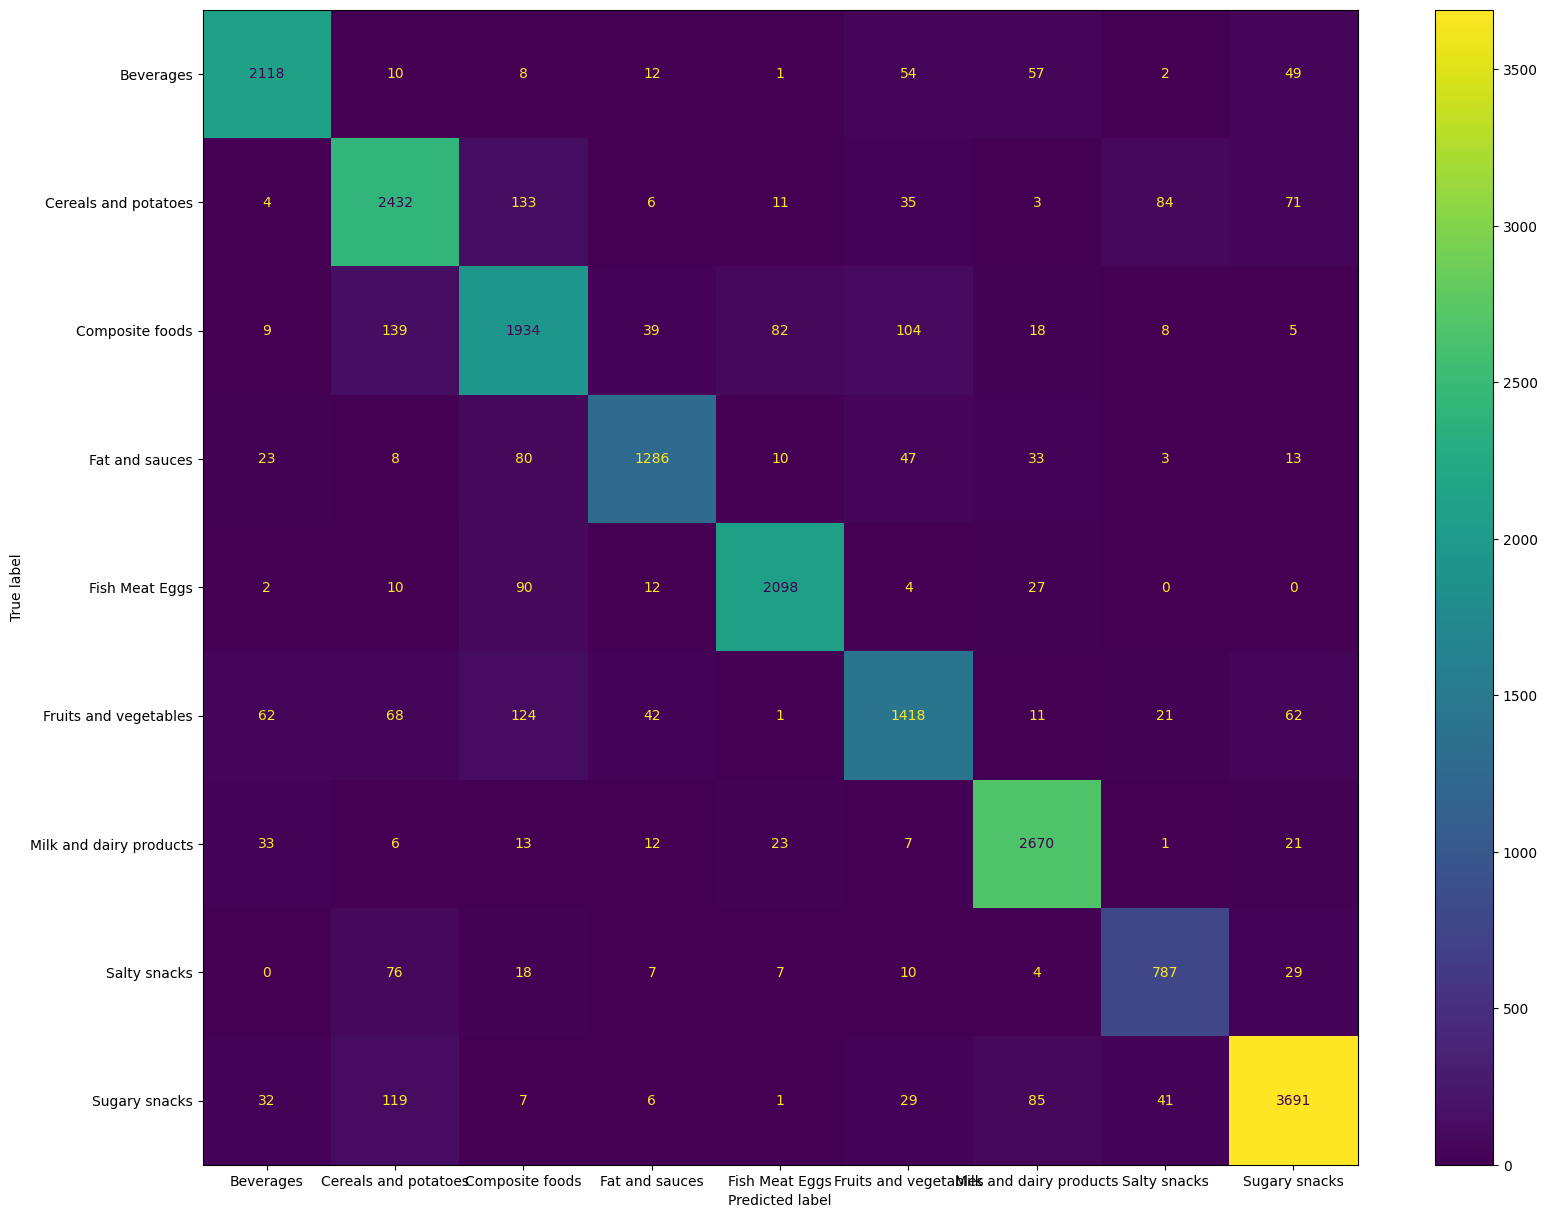

In [503]:
rcParams['figure.figsize'] = (20,15)
#On peut afficher une Confusion Matrix de nos résultats pour visualiser
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

On peut voir avec nos score qu'on a 89% de précision sur les estimations des catégories sur notre échantillon de test. C'est un très bon résultat, donc on va pouvoir s'en servir pour prédire les catégories des produits manquants qui nous serviront par la suite pour notre analyse. Pour cela on va donc maintenant fit notre algorithme sur le dataset 'full' contenant les catégories, puis on va prédire les catégories manquantes dans le reste du dataset complet.

In [504]:
y, X = full['pnns_groups_1'], full.drop(columns='pnns_groups_1')
pred = impute.drop(columns='pnns_groups_1')

knn = KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(X, y)
pred_pnns = knn.predict(pred)

F:\Data\Anaconda\envs\env\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [505]:
pd.Series(pred_pnns).value_counts()

Sugary snacks              34283
Cereals and potatoes       21287
Milk and dairy products    17689
Beverages                  15893
Composite foods            13484
Fat and sauces             11823
Salty snacks               10939
Fish Meat Eggs              9278
Fruits and vegetables       7711
dtype: int64

In [506]:
pred = pd.concat([pd.Series(pred_pnns),pred],axis=1)
pred

,0,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
0,Fruits and vegetables,0.506104,0.2857,0.2857,0.6429,0.1429,0.036,0.0357,0.000000,0.000000,0.058362,0.000467
1,Sugary snacks,0.453522,0.1786,0.0000,0.6071,0.1786,0.071,0.1786,0.006350,0.006350,0.000000,0.026192
2,Cereals and potatoes,0.632827,0.5714,0.0536,0.1786,0.0357,0.071,0.1786,0.012243,0.012243,0.000000,0.053674
3,Cereals and potatoes,0.435849,0.1875,0.0469,0.5781,0.1562,0.094,0.1406,0.001397,0.001397,0.000000,0.023993
4,Fat and sauces,0.870341,1.0000,0.0714,0.0000,0.0000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
142382,Cereals and potatoes,0.429123,0.1364,0.0455,0.7273,0.0909,0.046,0.0909,0.018237,0.018237,0.000000,0.000297
142383,Cereals and potatoes,0.391167,0.1053,0.0439,0.6667,0.1579,0.088,0.1228,0.000457,0.000457,0.000000,0.032152
142384,Sugary snacks,0.339612,0.0210,0.0120,0.7900,0.6800,0.064,0.0570,0.000600,0.000600,0.000000,0.000000
142385,Cereals and potatoes,0.337530,0.0972,0.0278,0.6111,0.3056,0.083,0.0556,0.009525,0.009525,0.189985,0.344203


In [507]:
pred.index = index_imput

In [508]:
pred

,0,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamins_100g,minerals_100g
0,Fruits and vegetables,0.506104,0.2857,0.2857,0.6429,0.1429,0.036,0.0357,0.000000,0.000000,0.058362,0.000467
1,Sugary snacks,0.453522,0.1786,0.0000,0.6071,0.1786,0.071,0.1786,0.006350,0.006350,0.000000,0.026192
2,Cereals and potatoes,0.632827,0.5714,0.0536,0.1786,0.0357,0.071,0.1786,0.012243,0.012243,0.000000,0.053674
3,Cereals and potatoes,0.435849,0.1875,0.0469,0.5781,0.1562,0.094,0.1406,0.001397,0.001397,0.000000,0.023993
4,Fat and sauces,0.870341,1.0000,0.0714,0.0000,0.0000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
194164,Cereals and potatoes,0.429123,0.1364,0.0455,0.7273,0.0909,0.046,0.0909,0.018237,0.018237,0.000000,0.000297
194168,Cereals and potatoes,0.391167,0.1053,0.0439,0.6667,0.1579,0.088,0.1228,0.000457,0.000457,0.000000,0.032152
194170,Sugary snacks,0.339612,0.0210,0.0120,0.7900,0.6800,0.064,0.0570,0.000600,0.000600,0.000000,0.000000
194177,Cereals and potatoes,0.337530,0.0972,0.0278,0.6111,0.3056,0.083,0.0556,0.009525,0.009525,0.189985,0.344203


In [509]:
products.loc[index_imput,'pnns_groups_1']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
194164    NaN
194168    NaN
194170    NaN
194177    NaN
194178    NaN
Name: pnns_groups_1, Length: 142387, dtype: object

In [510]:
products.loc[index_imput,'pnns_groups_1'] = pred[0]

In [511]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194181 entries, 0 to 194180
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   product_name        194181 non-null  object 
 1   brands              192148 non-null  object 
 2   nutrition_grade_fr  179759 non-null  object 
 3   pnns_groups_1       194181 non-null  object 
 4   pnns_groups_2       51930 non-null   object 
 5   energy_100g         194181 non-null  float64
 6   fat_100g            194181 non-null  float64
 7   saturated-fat_100g  194181 non-null  float64
 8   carbohydrates_100g  194181 non-null  float64
 9   sugars_100g         194181 non-null  float64
 10  fiber_100g          194181 non-null  float64
 11  proteins_100g       194181 non-null  float64
 12  salt_100g           194181 non-null  float64
 13  sodium_100g         194181 non-null  float64
 14  vitamins_100g       194181 non-null  float64
 15  minerals_100g       194181 non-nul

Concernant les variables qu'il nous reste, on va pour l'instant compléter par des unknown. Il nous reste des valeurs manquantes dans 'brands' qui ne nous intéresse pas tant que ça, dans 'nutrition_grade', qui va nous servir pour l'analyse mais on fera une séparation, et enfin 'pnns2', qu'on garde pour l'instant mais qu'on retirera rapidement dans l'analyse car on s'aperçoit qu'elle n'est pas très pratique.

In [512]:
products.fillna('unknown', inplace=True)

Avant de passer à l'étape d'analyse, on va maintenant refaire un nouveau tri de valeurs aberrantes, afin de retirer les valeurs qui ont pu se glisser dans nos précédents tris, ainsi que dans notre remplissage. Les lignes qu'on met en évidence maitenant vont simplement être retirées car on ne vas pas pouvoir les traiter.

In [516]:
products.drop(products.loc[products['saturated-fat_100g']>products['fat_100g']].index,inplace=True)# 567 lignes
products.reset_index(drop=True,inplace=True)
products.drop(products.loc[products['sugars_100g']>products['carbohydrates_100g']].index,inplace=True)# 1098 lignes
products.reset_index(drop=True,inplace=True)
products.drop(products.loc[products['fiber_100g']>products['carbohydrates_100g']].index,inplace=True)#898 lignes
products.reset_index(drop=True,inplace=True)

In [517]:
#On exporte notre jeu de données final afin de le traiter dans un notebook séparé pour l'analyse.
products.to_csv('products_clean.csv', index=False)